<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/googlenet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm
import time
import os
import copy
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
use_gpu

True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [4]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.1, 0.2), contrast=(0.1, 0.2), saturation=0.1, hue=0.1),
        transforms.RandomPerspective(0.3),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
data_dir = "/content/drive/MyDrive/LIBRAS"
num_workers = 12

image_datasets = {
    'train': datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'), 
        transform=transform
    ),
    'val': datasets.ImageFolder(
        root=os.path.join(data_dir, 'validation'), 
        transform=transform_test
    ),
    'test': datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'), 
        transform=transform_test
    )
}
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'], batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=128,
        shuffle=True, num_workers=num_workers
    )
}
pathloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'].imgs, batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'].imgs, batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'].imgs, batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
for x in ['train', 'test', 'val']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['test'].classes
print(image_datasets['train'].classes)
print(label)

Loaded 34714 images in train
Loaded 5783 images in test
Classes: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


# Creating Model

In [10]:
num_classes = len(os.listdir(data_dir + '/train'))
num_epochs = 5
learning_rate = 0.0005
weight_decay = 5e-4

model = torchvision.models.googlenet(weights='IMAGENET1K_V1')

model.fc = nn.Linear(1024, num_classes)

if use_gpu:
  model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

# Visualizing

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[label[x] for x in classes])

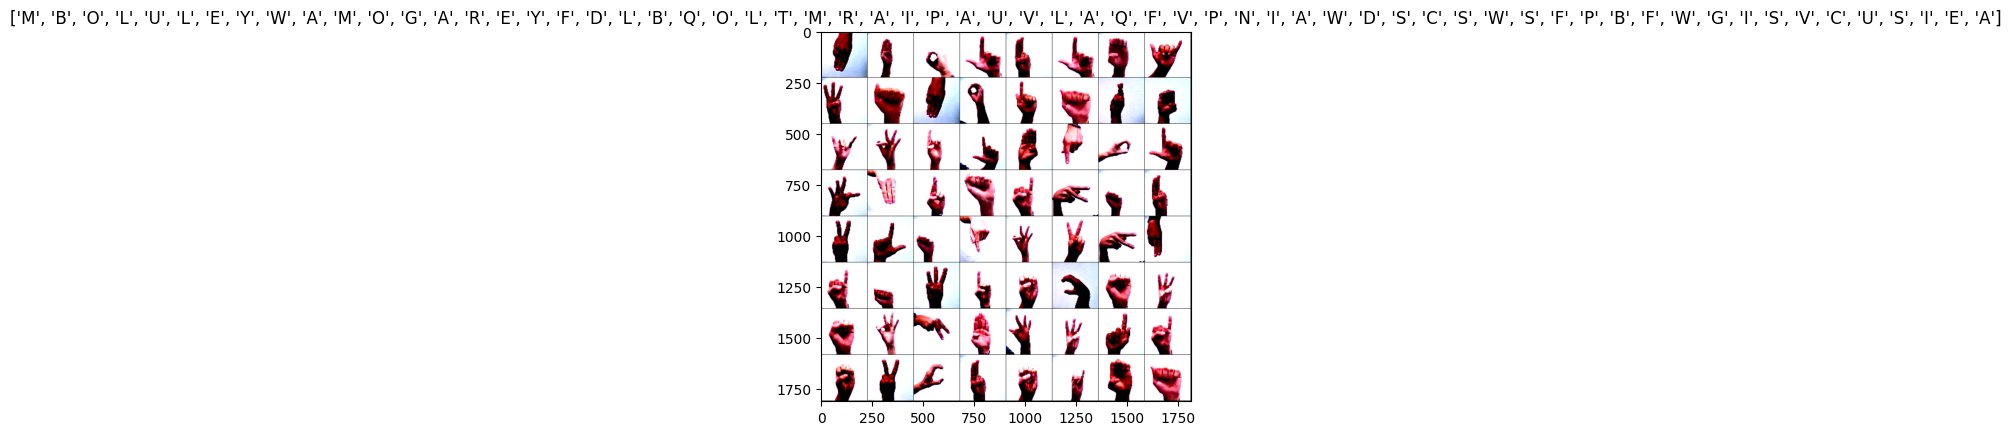

In [ ]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0
    
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training)

Ground truth:


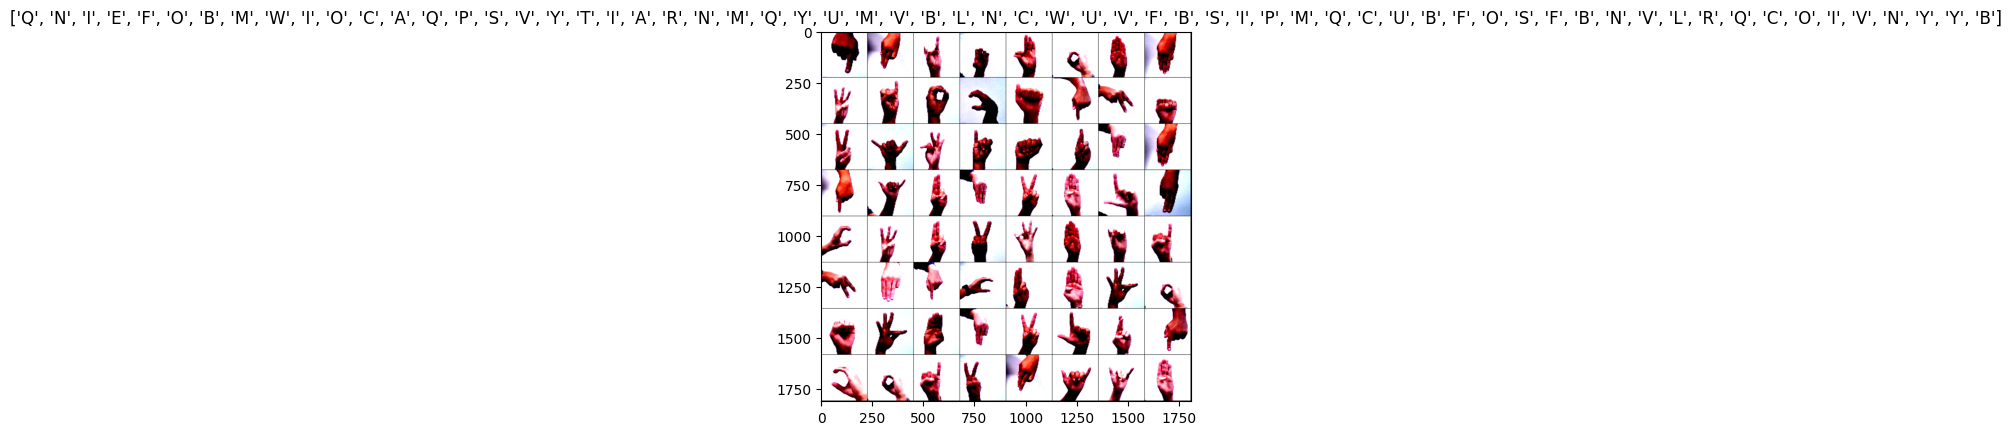

Prediction:


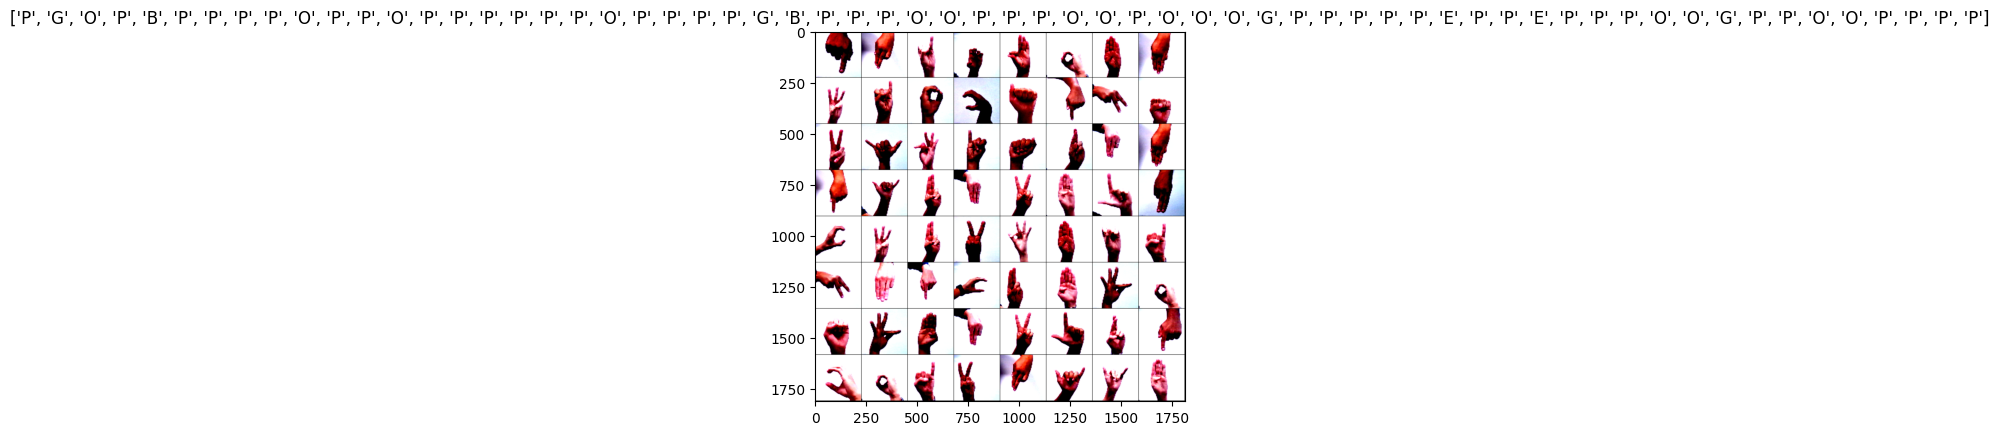

In [ ]:
visualize_model(model)

# Training

In [11]:
def train_model(model, criterion, optimizer, num_epochs=5):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    
    loss_values = []
    acc_values = []
    for epoch in tqdm(range(num_epochs)):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        model.train(True)
        pbar = tqdm(total=train_batches)
        for i, data in enumerate(dataloaders['train']):
            pbar.update(1)
                            
            inputs, labels= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss = loss_train  / dataset_sizes['train']
        avg_acc = acc_train  / dataset_sizes['train']
        loss_values.append((avg_loss, avg_loss_val))
        acc_values.append((avg_acc, avg_acc_val))
        model.train(False)
        model.eval()

        print("Running validation")
        y_true = []
        y_pred = []
        avg_loss_val = 0
        avg_acc_val = 0
        loss_test = 0
        acc_test = 0
        pbar = tqdm(total=len(dataloaders['val']))
        for i, data in enumerate(dataloaders['val']):
          pbar.update(1)
          
          inputs, labels = data
          
          y_true = y_true + labels.tolist()
          if use_gpu:
              with torch.no_grad():
                  inputs, labels = inputs.cuda(), labels.cuda()
          else:
              with torch.no_grad():
                  inputs, labels = inputs, labels
          
          outputs = model(inputs)

          _, preds = torch.max(outputs.data, 1)
          loss = criterion(outputs, labels)
          #print(preds)
          y_pred = y_pred + preds.tolist()
          
          loss_test += loss.item()
          acc_test += torch.sum(preds == labels.data)

          del inputs, labels, outputs, preds
          torch.cuda.empty_cache()

        avg_loss_val = loss_test / dataset_sizes['val']
        avg_acc_val = acc_test / dataset_sizes['val']
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (validation): {:.4f}".format(avg_loss_val))
        print("Avg acc (validation): {:.4f}".format(avg_acc_val))
        
        print()
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        # Adjust learning rate based on val loss
        lr_scheduler.step(avg_loss_val)

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

In [12]:
model,acc,loss = train_model(model, criterion, optimizer, num_epochs=num_epochs)
torch.save(model.state_dict(),'googlenet3_libras.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/272 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 0 result: 
Avg loss (validation): 0.0179
Avg acc (validation): 0.3479

Avg loss (train): 0.0021
Avg acc (train): 0.9310
----------

Epoch 1/4
----------


  0%|          | 0/272 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 result: 
Avg loss (validation): 0.0119
Avg acc (validation): 0.5141

Avg loss (train): 0.0003
Avg acc (train): 0.9904
----------

Epoch 2/4
----------


  0%|          | 0/272 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 result: 
Avg loss (validation): 0.0072
Avg acc (validation): 0.7722

Avg loss (train): 0.0002
Avg acc (train): 0.9925
----------

Epoch 3/4
----------


  0%|          | 0/272 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 result: 
Avg loss (validation): 0.0054
Avg acc (validation): 0.7884

Avg loss (train): 0.0002
Avg acc (train): 0.9934
----------

Epoch 4/4
----------


  0%|          | 0/272 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 result: 
Avg loss (validation): 0.0056
Avg acc (validation): 0.7741

Avg loss (train): 0.0002
Avg acc (train): 0.9943
----------


Training completed in 58m 3s
Best acc: 0.7884


Text(0.5, 1.0, 'GoogLeNet loss')

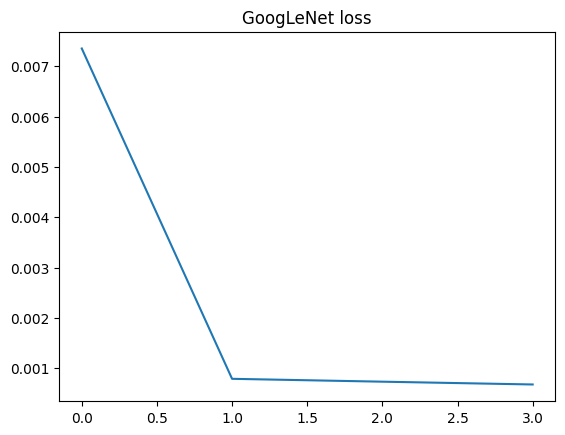

In [ ]:
plt.plot([it for it in loss[:-1]])
plt.title("GoogLeNet loss")

In [13]:
!ls

drive  googlenet3_libras.pt  sample_data


In [14]:
!cp  googlenet3_libras.pt drive/MyDrive/LIBRAS

# Evaluating

In [15]:
PATH = "googlenet3_libras.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
def eval_model(model, criterion):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    y_true = []
    y_pred = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    pbar = tqdm(total=test_batches)
    for i, data in enumerate(dataloaders['test']):
        pbar.update(1)

        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        y_true = y_true + labels.tolist()
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [17]:
criterion = nn.CrossEntropyLoss()
eval_model(model, criterion)

Evaluating model
----------


  0%|          | 0/46 [00:00<?, ?it/s]


Evaluation completed in 5m 39s
Avg loss (test): 0.0054
Avg acc (test): 0.7972
----------
